In [1]:
import numpy as np
import matplotlib.pyplot as plt
import math
import scipy
import pandas as pd
from collections import defaultdict
from numpy.linalg import norm, inv
from scipy.spatial.distance import euclidean
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [3]:
movies_data = pd.read_csv('/content/gdrive/My Drive/6701/hw2/movies.csv')
ratings_data = pd.read_csv('/content/gdrive/My Drive/6701/hw2/ratings.csv')
train_data, test_data = train_test_split(ratings_data)
ratings_array = np.asarray(ratings_data)
train_array = np.asarray(train_data)
test_array = np.asarray(test_data)
train_data

,userId,movieId,rating,timestamp
11615,68,164179,3.5,1526947647
69939,448,86028,2.0,1332090711
33724,229,527,4.0,838144399
14146,91,150,3.5,1112712023
27822,188,2302,5.0,962559903
...,...,...,...,...
36972,249,61348,1.0,1346758376
70976,453,2126,1.0,972621007
34387,232,32596,3.0,1218167769
62966,414,2005,5.0,961594916


In [4]:
# user_index: dict() user id -> user index
userId = np.unique(np.asarray(ratings_data['userId']))
user_index = defaultdict(int)
num_users = 0
for u in userId:
  user_index[u] = num_users
  num_users += 1

# movie_index: dict() movie id -> movie index
movieId = np.unique(np.asarray(ratings_data['movieId']))
movie_index = defaultdict(int)
num_movies = 0
for m in movieId:
  movie_index[m] = num_movies
  num_movies += 1

print(num_users, num_movies)

610 9724


In [5]:
# user_dict : dict() user id -> movie id which user gave rating
user_dict = defaultdict(list)
# movie_dict : dict() movie id -> user id which user gave rating
movie_dict = defaultdict(list)
# rating_dict : dict() (user id, movie id) -> rating
train_ratings_dict = defaultdict(float)

for r in train_array:
  if r[0] in user_dict:
    user_dict[int(r[0])].append(int(r[1]))
  else:
    user_dict[int(r[0])] = [int(r[1])]
  if r[1] in movie_dict:
    movie_dict[int(r[1])].append(int(r[0]))
  else:
    movie_dict[int(r[1])] = [int(r[0])]

  train_ratings_dict[(int(r[0]), int(r[1]))]= r[2]

In [6]:
def initialise_umat():
  u_mat=[]
  for i in range(num_users):
    u_mat.append(np.random.multivariate_normal(mean=np.zeros(10), cov=np.identity(10), size=1)[0])
  u_mat= np.asarray(u_mat)
  return u_mat

def initialise_vmat():
  v_mat=[]
  for i in range(num_movies):
    v_mat.append(np.random.multivariate_normal(mean=np.zeros(10), cov=np.identity(10), size=1)[0])
  v_mat= np.asarray(v_mat)
  return v_mat

In [7]:
def f_UV(u_mat, v_mat, ratings_array, lambda_u=0.25, lambda_v=0.25, bias=False, bu=None, bv=None, mu=None):
  term_1 = 0
  for i in range(0, len(ratings_array)):
    idx_u = int(ratings_array[i][0]) 
    idx_m = int(ratings_array[i][1]) 
    temp_term = ratings_array[i][2] - u_mat[user_index[idx_u]].dot(v_mat[movie_index[idx_m]])
    if bias:
      temp_term -= bu[user_index[idx_u]] + bv[movie_index[idx_m]] + mu
    term_1 += temp_term**2

  term_2 = 0
  for u in range(num_users):
    term_2 += norm(u_mat[u])**2
    if bias:
      term_2 += bu[u] ** 2

  term_3 = 0
  for m in range(num_movies):
    term_3 += norm(v_mat[m])**2
    if bias:
      term_3 += bv[m]**2
 
  return term_1 + lambda_u*term_2 + lambda_v*term_3

In [8]:
def update_user_location(u_id, v, lambda_u=0.25, bias=False, bv=None, mu=None):
  L = v.shape[1]
  rt_term = np.zeros(L)
  movie_set = user_dict[u_id]
  R = np.array([train_ratings_dict[(u_id, v_id)] for v_id in movie_set])
  R = R[:,np.newaxis]
  movie_index_set = [int(movie_index[m]) for m in movie_set]

  m = lambda_u * np.identity(L)
  m = m + v[movie_index_set].T.dot(v[movie_index_set])
  if bias:
    d = v[movie_index_set].T.dot(R - mu - bv[movie_index_set,np.newaxis])
  else:
    d = v[movie_index_set].T.dot(R)
  result = inv(m).dot(d)
  return result[:,0]

def update_object_location(v_id, u, lambda_v=0.25, bias=False, bu=None, mu=None):
  L = u.shape[1]
  rt_term = np.zeros(L)
  user_set = movie_dict[v_id]
  R = np.array([train_ratings_dict[(u_id, v_id)] for u_id in user_set])
  R = R[:,np.newaxis]
  user_index_set = [int(user_index[u]) for u in user_set]

  m = lambda_v * np.identity(L)
  m = m + u[user_index_set].T.dot(u[user_index_set])

  if bias:
    d = u[user_index_set].T.dot(R - mu - bu[user_index_set,np.newaxis])
  else:
    d = u[user_index_set].T.dot(R)
  result = inv(m).dot(d)
  return result[:,0]

In [9]:
#goes from i=1 to N1 (number of user locations), updating each row
def update_u(u_mat, v_mat, lambda_u=0.25, bias=False, bv=None, mu=None):
  for id in user_index.keys():
    index = user_index[id]
    u_mat[index] = update_user_location(id, v_mat, lambda_u, bias, bv, mu)
  return u_mat

def update_v(u_mat, v_mat, lambda_v=0.25, bias=False, bu=None, mu=None):
  for id in movie_index.keys():
    index = movie_index[id]
    v_mat[index] = update_object_location(id, u_mat, lambda_v, bias, bu, mu)
  return v_mat

In [10]:
def run_MAP_coor_ascent(num_of_iterations=20, bias=False):
  u = initialise_umat()
  v = initialise_vmat()
  F_values=[]
  Train_rmse = []
  Test_rmse = []
  bu = None
  bv = None
  mu = None
  Converge = False
  last_train_rmse = 100
  if bias:
    bu = np.zeros(num_users)
    bv = np.zeros(num_movies)
    mu = np.mean(train_data['rating'])

  for i in range(num_of_iterations):
    if i % (num_of_iterations//min(10, num_of_iterations)) == 0:
      print('.',end='')
    
    if bias:
      v = np.c_[np.ones(num_movies),v]
      u = np.c_[bu,u]
    u = update_u(u,v,lambda_u,bias,bv,mu)
    if bias:
      bu = u[:,0]
      u = u[:,1:]
      v = v[:,1:]
    if bias:
      v = np.c_[bv,v]
      u = np.c_[np.ones(num_users) ,u]
    v = update_v(u,v,lambda_v,bias,bu,mu)
    if bias:
      bv = v[:,0]
      v = v[:,1:]
      u = u[:,1:]

    f = f_UV(u,v,train_array,lambda_u,lambda_v,bias,bu,bv,mu)
    F_values.append(f)
    # print(f)

    train_predict = predict_ratings(train_array, u, v, bias, bu, bv, mu)
    train_predict[train_predict>5] = 5
    train_predict[train_predict<0] = 0
    train_rmse = math.sqrt(mean_squared_error(np.asarray(train_data['rating']), train_predict))
    Train_rmse.append(train_rmse)
    # print(train_rmse)
    
    test_predict = predict_ratings(test_array, u, v, bias, bu, bv, mu)
    test_predict[test_predict>5] = 5
    test_predict[test_predict<0] = 0
    test_rmse = math.sqrt(mean_squared_error(np.asarray(test_data['rating']), test_predict))
    Test_rmse.append(test_rmse)
    # print(test_rmse)

    if abs(last_train_rmse - train_rmse) <= 0.001:
      Converge = True
      break
    last_train_rmse = train_rmse
  if Converge:
    print('Algorithm convergence on training data for %d steps!' % (i+1))
  else:
    print('Maximum number of iterations reached!')
  return u, v, F_values, Train_rmse, Test_rmse

In [11]:
def predict_ratings(data, u_mat, v_mat, bias=False, bu=None, bv=None, mu=None):
  preds=[]
  for i in range(len(data)):
    # print(data)
    u_idx = user_index[int(data[i][0])]
    v_idx = movie_index[int(data[i][1])]
    u_vect = u_mat[u_idx]
    v_vect = v_mat[v_idx]
    
    if bias:
      bu_num = bu[u_idx]
      bv_num = bv[v_idx]
      m = u_vect.dot(v_vect) + mu + bu_num + bv_num
    else:
      m = u_vect.dot(v_vect)
    rating = np.random.normal(m, 0.25, 1)[0]

    preds.append(rating)                         
  return np.array(preds)

In [12]:
def run(n=10, bias=False):
  #Looping over 10 runs
  run_results_dict = {}
  for i in range(n):
    results_dict = {}
    u_mat, v_mat, F_values, Train_rmse, Test_rmse = run_MAP_coor_ascent(50, bias)

    results_dict["Train_rmse"]= Train_rmse
    results_dict["Test_rmse"]= Test_rmse
    results_dict["F_values"]= F_values
    results_dict["u"]= u_mat
    results_dict["v"]= v_mat

    run_results_dict[i] = results_dict

  return run_results_dict

In [73]:
lambda_u = 10
lambda_v = 10
result_dict = run(10, bias=False)
result_dict_bias = run(10, bias=True)

...Algorithm convergence on training data for 11 steps!
...Algorithm convergence on training data for 11 steps!
...Algorithm convergence on training data for 12 steps!
...Algorithm convergence on training data for 11 steps!
...Algorithm convergence on training data for 12 steps!
...Algorithm convergence on training data for 11 steps!
...Algorithm convergence on training data for 12 steps!
....Algorithm convergence on training data for 17 steps!
...Algorithm convergence on training data for 13 steps!
...Algorithm convergence on training data for 12 steps!
...Algorithm convergence on training data for 14 steps!
..Algorithm convergence on training data for 9 steps!
..Algorithm convergence on training data for 8 steps!
..Algorithm convergence on training data for 10 steps!
..Algorithm convergence on training data for 9 steps!
..Algorithm convergence on training data for 8 steps!
..Algorithm convergence on training data for 7 steps!
..Algorithm convergence on training data for 10 steps!
..A

In [14]:
def cal_metric(result_dict, metric):
  mean_metric = []
  std_metric = []
  max_len = 0
  j = 0
  while True:
    now_metric = []
    count = 0
    for i in result_dict.keys():
      try:
        now_metric += [result_dict[i][metric][j]]
        count += 1
      except:
        continue
    if count == 0:
      break
    mean_metric += [np.mean(now_metric)]
    std_metric += [np.std(now_metric)]
    j += 1
  return mean_metric, std_metric

def plot_metric(result_dict, result_dict_bias, metric, title):
  
  result_mean, result_std = cal_metric(result_dict, metric)
  result_bias_mean, result_bias_std = cal_metric(result_dict_bias, metric)
  
  plt.plot(range(len(result_mean)), result_mean, color='orange', label='No biases')
  plt.plot(range(len(result_bias_mean)), result_bias_mean, color='blue', label='With biases')
  plt.title(title)
  plt.ylabel(metric)
  plt.xlabel('iters')
  plt.legend()
  plt.savefig('/content/gdrive/My Drive/6701/HW2/'+metric+'.jpg')

  print('The minimum value of', metric, 'on original model is:', round(min(result_mean),4))
  print('The minimum value of', metric, 'on biases model is:', round(min(result_bias_mean),4))


The minimum value of Train_rmse on original model is: 0.8011
The minimum value of Train_rmse on biases model is: 0.6988


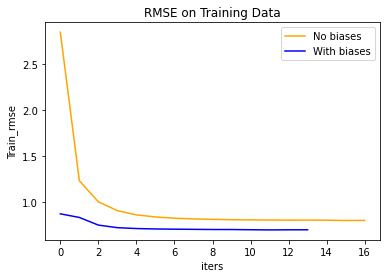

In [74]:
plot_metric(result_dict, result_dict_bias, 'Train_rmse', 'RMSE on Training Data')

The minimum value of Test_rmse on original model is: 1.2769
The minimum value of Test_rmse on biases model is: 0.8987


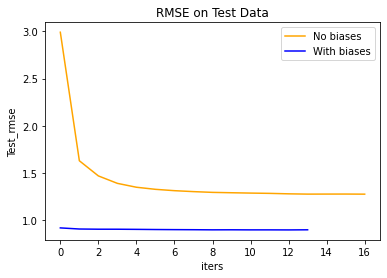

In [75]:
plot_metric(result_dict, result_dict_bias, 'Test_rmse', 'RMSE on Test Data')

The minimum value of F_values on original model is: 153485.4014
The minimum value of F_values on biases model is: 47991.5226


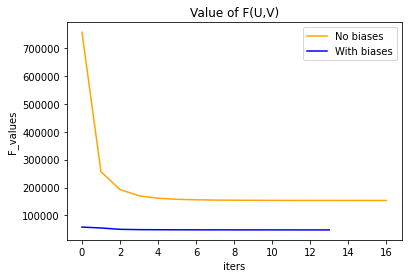

In [76]:
plot_metric(result_dict, result_dict_bias, 'F_values', 'Value of F(U,V)')

In [77]:
def top_k_closest(k, name, v_mat):
  result = []
  result_distances = []
  result_idx = []
  dists = []
  
  idx = movie_index[name]
  vidx = v_mat[idx]

  for i in range(len(v_mat)):
    if i != idx:
      euc_distance = euclidean(vidx, v_mat[i])
      dists.append((euc_distance, i))
    
  dists = sorted(dists, key=lambda x: x[0])

  for i in range(k):
    dist_idx, idx = dists[i][0], dists[i][1]
    name = index_movie[idx]
    result.append(name)
    result_distances.append(dist_idx)
    result_idx.append(idx)
  
  return result, result_distances, result_idx

In [78]:
def print_k_closest(k, movie_name, v_mat, movie_id=None):
  if movie_id:
    movie_name = index_movie[movie_id]
  else:
    movie_id = movie_index[movie_name]

  print('Original movie: %s, Genres: %s' %(movies_data.iloc[movie_column[movie_name]][1], movies_data.iloc[movie_column[movie_name]][2]))
  result, result_distances, result_idx = top_k_closest(k, movie_name, v_mat)
  
  for i in range(k):
    if (i+1) % 10 == 1:
      print('%dst close movie: %s, Genres: %s' %(i+1, movies_data.iloc[movie_column[result[i]]][1], movies_data.iloc[movie_column[result[i]]][2]))
    elif (i+1) % 10 == 2:
      print('%dnd close movie: %s, Genres: %s' %(i+1, movies_data.iloc[movie_column[result[i]]][1], movies_data.iloc[movie_column[result[i]]][2]))
    elif (i+1) % 10 == 3:
      print('%drd close movie: %s, Genres: %s' %(i+1, movies_data.iloc[movie_column[result[i]]][1], movies_data.iloc[movie_column[result[i]]][2]))
    else:
      print('%dth close movie: %s, Genres: %s' %(i+1, movies_data.iloc[movie_column[result[i]]][1], movies_data.iloc[movie_column[result[i]]][2]))

In [79]:
# index_movie: dict() movie index -> movie id
index_movie = defaultdict(int)
for k in movie_index.keys():
  index_movie[movie_index[k]] = k
# movie_column: dict() movie id -> row of movie column in movies_data
movie_column = defaultdict(int)
for i in range(len(movies_data)):
  movie_column[movies_data.iloc[i][0]] = i

In [80]:
u, v, F_values, Train_rmse, Test_rmse = run_MAP_coor_ascent(num_of_iterations=20, bias=True)

.....Algorithm convergence on training data for 9 steps!


In [82]:
print_k_closest(12, 122892, v, movie_id=None)

Original movie: Avengers: Age of Ultron (2015), Genres: Action|Adventure|Sci-Fi
1st close movie: Primal Fear (1996), Genres: Crime|Drama|Mystery|Thriller
2nd close movie: Star Trek (2009), Genres: Action|Adventure|Sci-Fi|IMAX
3rd close movie: X-Men: Days of Future Past (2014), Genres: Action|Adventure|Sci-Fi
4th close movie: War for the Planet of the Apes (2017), Genres: Action|Adventure|Drama|Sci-Fi
5th close movie: Uncle Nino (2003), Genres: Comedy
6th close movie: Thor: The Dark World (2013), Genres: Action|Adventure|Fantasy|IMAX
7th close movie: Confidence (2003), Genres: Crime|Thriller
8th close movie: Armour of God (Long xiong hu di) (1987), Genres: Action|Adventure|Comedy
9th close movie: Brave (2012), Genres: Action|Adventure|Animation|Children
10th close movie: Thor (2011), Genres: Action|Adventure|Drama|Fantasy|IMAX
11st close movie: How to Train Your Dragon 2 (2014), Genres: Action|Adventure|Animation
12nd close movie: X-Files: Fight the Future, The (1998), Genres: Action|Cr

In [72]:
lu = [0.01,0.1,1,10,100,1000]
lv = [0.01,0.1,1,10,100,1000]
for lambda_u in lu:
  for lambda_v in lv:
    u, v, F_values, Train_rmse, Test_rmse = run_MAP_coor_ascent(num_of_iterations=50, bias=True)
    print(lambda_u, lambda_v, min(Train_rmse), min(Test_rmse))

....Algorithm convergence on training data for 19 steps!
0.01 0.01 0.48410952185990175 1.0777254013831064
...Algorithm convergence on training data for 13 steps!
0.01 0.1 0.4927114751136188 0.9877765116279383
....Algorithm convergence on training data for 20 steps!
0.01 1 0.48251240623487557 0.9327745321059498
...Algorithm convergence on training data for 12 steps!
0.01 10 0.5022275341640026 0.9255350909238045
...Algorithm convergence on training data for 11 steps!
0.01 100 0.5242715235966501 0.9561830060315935
...Algorithm convergence on training data for 11 steps!
0.01 1000 0.5792820066598773 0.9191380706334362
....Algorithm convergence on training data for 19 steps!
0.1 0.01 0.4848878896061971 1.068206224837131
....Algorithm convergence on training data for 17 steps!
0.1 0.1 0.4878494511377825 0.9912967879861576
...Algorithm convergence on training data for 15 steps!
0.1 1 0.49178012366702517 0.9333728817305796
..Algorithm convergence on training data for 10 steps!
0.1 10 0.52248861